<span style="font-size:35px; font-weight:bold;margin-left: 150px;color:#06445e;"> LinkedIn Scraping and Analysis of Job Postings</span>
<span style="font-size:35px; font-weight:bold;margin-left: 180px;color:#06445e;"> ---------------------------------------------------</span>

<span style="font-size:30px; font-weight:bold;color:#06445e;"> (1) Import necessary libraries </span>

### ***`pandas:`*** For data manipulation and analysis (DataFrames, filtering, etc.)
### ***`Counter:`*** For counting hashable objects (skill frequencies, job counts)

In [4]:
import pandas as pd
from collections import Counter

### ***`matplotlib:`*** Base plotting library for creating static, interactive visualizations
### ***`seaborn:`*** Built on matplotlib, provides high-level interface for statistical graphics

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

### ***`webdriver:`*** The main Selenium module that allows browser automation
### ***`By:`*** Provides different strategies to locate elements (ID, class, CSS, XPath, etc.)
### ***`chrome_options:`*** Configures Chrome browser settings and preferences

In [8]:
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.options import Options

### ***`time:`*** For adding delays (time.sleep()) and handling timing operations
### ***`random:`*** For generating random numbers (useful for varying wait times)

In [11]:
import time
import random

### ***`rich:`*** Provides enhanced console output with colors and formatting (optional)

In [13]:
from rich import print

<span style="font-size:55px; font-weight:bold">______________________________________________</span>
<span style="font-size:35px; font-weight:bold;color:#06445e;">(2) 🔍 LinkedIn Job Scraping with Selenium</span>

### A) It ***automates a web browser*** to open a LinkedIn jobs page 
### B) Locates and extracts key information ***(job title, company, and location)*** from the listings
### C) The driver URL for the job search ***is customized***, you can change it to your job titles and filters applied

In [16]:
def linkedin_selenium_scraping():
    """
    Attempt to scrape LinkedIn using Selenium and return the scraped data and the driver.
    """
    # LinkedIn URL - This is the URL the script will use.
    url = "https://www.linkedin.com/jobs/search/?keywords=junior%20data%20analyst"
    
    print("Setting up Selenium browser...")
    
    # Set up Chrome options
    chrome_options = Options()
    chrome_options.add_argument("--disable-blink-features=AutomationControlled")
    chrome_options.add_experimental_option("excludeSwitches", ["enable-automation"])
    chrome_options.add_argument("--start-maximized")
    
    driver = None 
    try:
        driver = webdriver.Chrome(options=chrome_options)
        
        print("Opening LinkedIn...") 
        driver.get("https://www.linkedin.com/jobs/search?keywords=SQL%2C%20Python%2C%20Excel%2C%20Power%20BI&location=United%20States&geoId=103644278&trk=public_jobs_jobs-search-bar_search-submit&position=1&pageNum=0")
        
        # Wait for page to load
        time.sleep(5)
        
        if "login" in driver.current_url or "signin" in driver.current_url:
            print("LinkedIn is asking for login. Manual intervention needed.")
            print("Please login manually in the browser window, then press Enter here to continue...")
            input()  
        
        print("Waiting for job listings to load...")
        time.sleep(3)
        
        try:
            selectors_to_try = [
                '.base-search-card__info',
                '.job-search-card',
                '.jobs-search-results__list-item',
                '[data-job-id]'
            ]
            
            job_elements = []
            for selector in selectors_to_try:
                job_elements = driver.find_elements(By.CSS_SELECTOR, selector)
                if job_elements:
                    print(f"Found {len(job_elements)} job elements using selector: {selector}")
                    break
            
            if not job_elements:
                print("No job elements found. LinkedIn's structure may have changed.")
                print(f"Current URL: {driver.current_url}")
                print(f"Page title: {driver.title}")
                return [], driver
            
            jobs_data = []
            
            for i, job_element in enumerate(job_elements[:16]):
                try:
                    title = job_element.find_element(By.CSS_SELECTOR, '.base-search-card__title').text
                    company = job_element.find_element(By.CSS_SELECTOR, '.hidden-nested-link').text
                    location = job_element.find_element(By.CSS_SELECTOR, '.job-search-card__location').text
                    
                    # Extract date with its own try-except block
                    posted_date = "Date not found"
                    try:
                        date_element = job_element.find_element(By.CSS_SELECTOR, 'time')
                        posted_date = date_element.text.strip()
                    except:
                        pass
                    
                    # This line is causing an error because the function is not defined.
                    skills = extract_skills_from_title(title)
                    
                    jobs_data.append({
                        'title': title,
                        'company': company,
                        'location': location,
                        'posted_date': posted_date,
                        'skills': skills,
                        'index': i + 1
                    })
                    
                except Exception as e:
                    print(f"Error extracting data from job {i}: {e}")
                    continue
            
            print(f"Successfully extracted data from {len(jobs_data)} jobs")
            return jobs_data, driver
            
        except Exception as e:
            print(f"Error finding job elements: {e}")
            return [], driver
            
    except Exception as e:
        print(f"Failed to initialize Selenium: {e}")
        print("Make sure you have installed Selenium and have a compatible ChromeDriver in your PATH.")
        return [], None

<span style="font-size:35px; font-weight:bold;color:#06445e;">Extract skills from job title using keyword matching</span>

In [18]:
def extract_skills_from_title(title):

    skill_keywords = {
        'SQL': ['sql', 'database', 'mysql', 'postgresql'],
        'Python': ['python', 'pandas', 'numpy'],
        'Excel': ['excel', 'spreadsheet'],
        'Tableau': ['tableau','TABLEAU', 'Tableau'],
        'Power BI': ['power bi', 'powerbi', 'Power Bi'],
        'R': ['r ', 'r,', 'r-programming'],
        'Statistics': ['statistic', 'analytics'],
        'Machine Learning': ['machine learning', 'ml'],
        'Data Visualization': ['visualization', 'dashboard'],
        'AWS': ['aws', 'amazon web services'],
        'Azure': ['azure', 'microsoft azure']
    }
    
    detected_skills = []
    title_lower = title.lower()
    
    for skill, keywords in skill_keywords.items():
        if any(keyword in title_lower for keyword in keywords):
            detected_skills.append(skill)
    
    return detected_skills if detected_skills else ['Data Analysis']

<span style="font-size:35px; font-weight:bold;color:#06445e;">Main Script Execution</span>

In [21]:
print("[bold]✅ Starting LinkedIn scraping with Selenium...[/bold]")
jobs_data, driver = linkedin_selenium_scraping()

if jobs_data:
    df = pd.DataFrame(jobs_data)
    
    # Drop the 'index' column
    df = df.drop(columns=['index'])
    
    print("[bold]\n💻 Scraped Job Data:[/bold]")
    print("=" * 20)
    display(df.head(16))

✅ Starting LinkedIn scraping with Selenium...

Setting up Selenium browser...

Opening LinkedIn...

Waiting for job listings to load...

Found 60 job elements using selector: .base-search-card__info

Successfully extracted data from 16 jobs

💻 Scraped Job Data:

====================

,title,company,location,posted_date,skills
0,BI Developer,LinkedIn,"Sunnyvale, CA",1 week ago,[Data Analysis]
1,"Data Analyst, Research and Strategy",Lantern,United States,2 weeks ago,[Data Analysis]
2,Power BI Developer,Veracity Software Inc,"Iselin, NJ",3 months ago,"[Power BI, R]"
3,Data Analyst,The Value Maximizer,"Austin, TX",1 week ago,[Data Analysis]
4,Data Analyst - Remote,Guidehealth,"Chicago, IL",1 month ago,[Data Analysis]
5,"Analyst, Demand Generation Performance",Freshworks,"San Mateo, CA",3 days ago,[Data Analysis]
6,Data Visualization / PowerBI Expert,Gap International,"Springfield, PA",3 days ago,"[Power BI, Data Visualization]"
7,Data Analyst,The Value Maximizer,"New Jersey, United States",1 week ago,[Data Analysis]
8,PowerBI Developer,JCW Group,United States,1 week ago,[Power BI]
9,Data Analyst,Go Offer,United States,2 weeks ago,[Data Analysis]


<span style="font-size:35px; font-weight:bold;color:#06445e;">Export as CSV & Close the driver</span>

In [43]:
print(f"[bold]🔮 Extracted data from: {len(df)} jobs successfully [/bold]")
    
# Save to CSV
print("[bold]\n🔃 Downloading your LinkedIn jobs excel...[/bold]")
time.sleep(2)
df.to_csv('linkedin-Data-Analyst-jobs-by-Selenium.csv')
print("[bold]\n✅ Data saved to linkedin_jobs.csv[/bold]")

# Ensure the driver is closed only after all operations are complete
if driver:
    time.sleep(1)
    print("[bold]\n💨 Press Enter to close the browser...[/bold]")
    input()
    driver.quit()
    print("[bold]🔴 Browser closed.[bold]")

🔮 Extracted data from: 16 jobs successfully 

🔃 Downloading your LinkedIn jobs excel...

✅ Data saved to linkedin_jobs.csv

💨 Press Enter to close the browser...

🔴 Browser closed.

<span style="font-size:55px; font-weight:bold">______________________________________________</span>
<span style="font-size:35px; font-weight:bold;color:#06445e;">(3) Data Visualization 📊</span>
## ***1. Bar Chart: Jobs per Company***

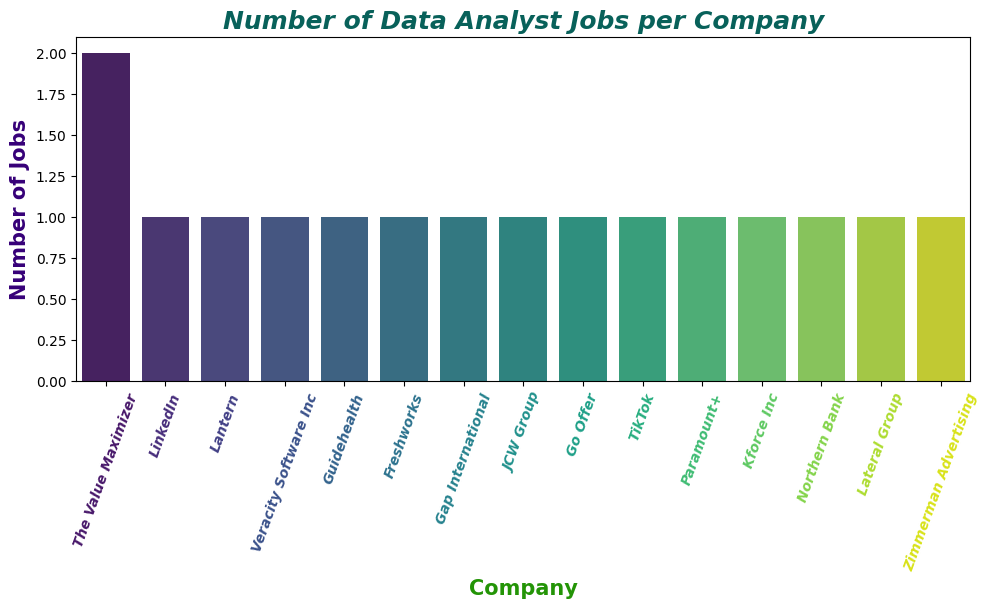

In [31]:
import warnings
warnings.filterwarnings('ignore')


plt.figure(figsize=(10, 6))
company_counts = df['company'].value_counts()
ax = sns.barplot(x=company_counts.index, y=company_counts.values, palette='viridis')

plt.title('Number of Data Analyst Jobs per Company', fontsize=18, fontweight='bold', style='italic', color="#08615A")
plt.xlabel('Company', fontsize=15, fontweight='bold', color="#239406")
plt.ylabel('Number of Jobs', fontsize=15, fontweight='bold', color="#360078")
plt.xticks(rotation=70, ha='center')
plt.tight_layout()

# Get the colors from the palette used by Seaborn
palette = sns.color_palette("viridis", n_colors=len(company_counts))

# Iterate through the x-tick labels and set their color
for i, ticklabel in enumerate(ax.get_xticklabels()):
    ticklabel.set_color(palette[i])
    ticklabel.set_fontweight('bold')
    ticklabel.set_fontstyle('italic')

plt.show()

## ***2. Bar Chart: Jobs per Location***
## ***====================***

## ***Note on Location Data:***
## You may observe duplicate or similar city names in the location data, such as
## ***`NY, United States`*** OR ***`New York, US`*** OR ***`New York City`*** This is due to variations in
## how companies format their location information on LinkedIn.

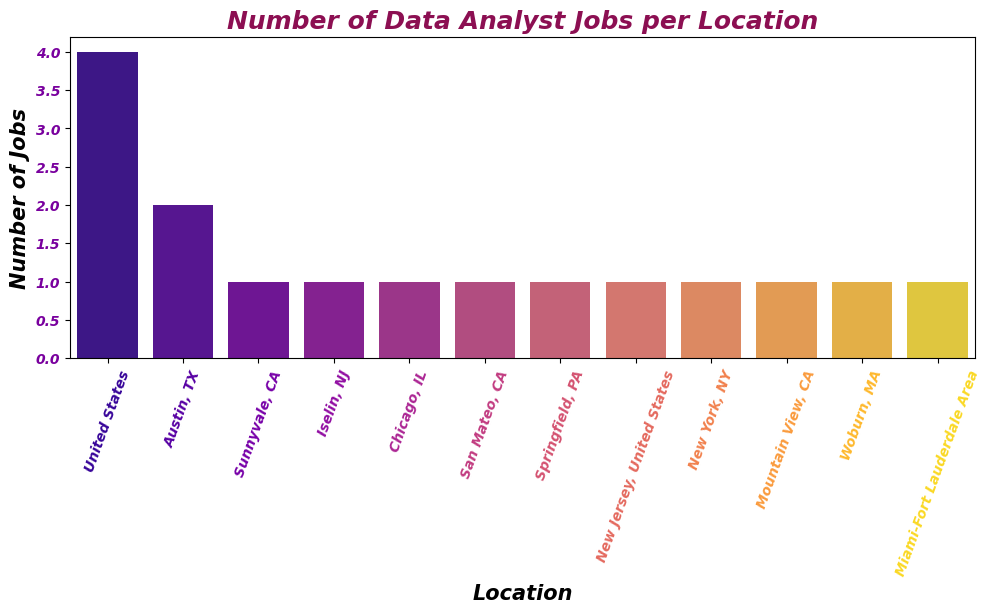

In [35]:
plt.figure(figsize=(10, 6))
location_counts = df['location'].value_counts()
ax = sns.barplot(x=location_counts.index, y=location_counts.values, palette='plasma')

plt.title('Number of Data Analyst Jobs per Location', fontsize=18, fontweight='bold', style='italic', color='#8C0F52')
plt.xlabel('Location', fontsize=15, fontweight='bold', style='italic')
plt.ylabel('Number of Jobs', fontsize=15, fontweight='bold', style='italic')
plt.xticks(rotation=70, ha='center')
plt.tight_layout()

# Get the colors from the palette used by Seaborn for x-axis labels
palette = sns.color_palette("plasma", n_colors=len(location_counts))

# Set the color, font weight, and font style of the x-tick labels
for i, ticklabel in enumerate(ax.get_xticklabels()):
    ticklabel.set_color(palette[i])
    ticklabel.set_fontweight('bold')
    ticklabel.set_fontstyle('italic')

# Set the font weight and font style of the y-tick labels
for ticklabel in ax.get_yticklabels():
    ticklabel.set_color('#79009E')
    ticklabel.set_fontweight('bold')
    ticklabel.set_fontstyle('italic')

plt.show()

<span style="font-size:55px; font-weight:bold">______________________________________________</span>
<span style="font-size:35px; font-weight:bold;color:#06445e;">✨(Bonus)</span>
## ***1. Bar Chart: Overall top skills***

Top skills overall:
[('Data Analysis', 12), ('Power BI', 4), ('R', 2), ('Data Visualization', 1)]

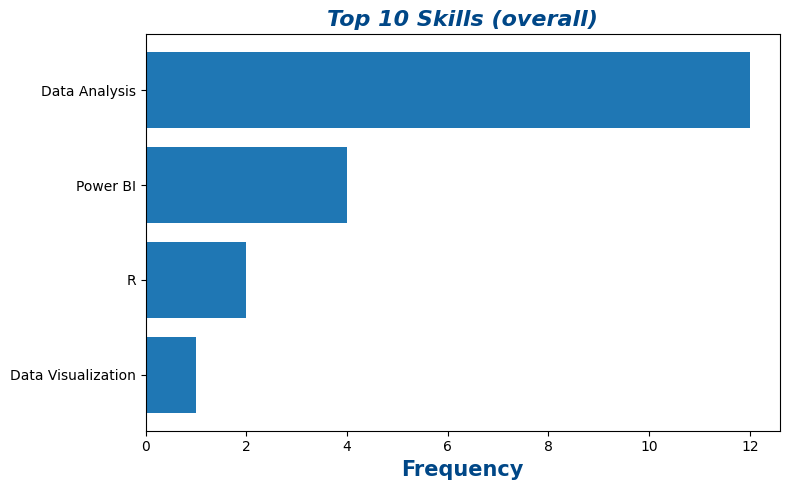

In [38]:
all_skills = Counter(s for lst in df["skills"] for s in lst)
print("[bold]Top skills overall:[/bold]", all_skills.most_common(15))

# Plot top 10
top10 = all_skills.most_common(10)
if top10:
    names, counts = zip(*top10)
    plt.figure(figsize=(8,5))
    plt.barh(list(names)[::-1], list(counts)[::-1])
    plt.title("Top 10 Skills (overall)", fontsize=16, fontweight='bold', style='italic', color='#004787')
    plt.xlabel("Frequency", fontsize=15, fontweight='bold', color='#004787')
    plt.tight_layout()
    plt.show()


## ***2. Skills by top cities***

================================================================================

Top skills in United States:
[('Data Analysis', 2), ('Power BI', 2), ('R', 1)]

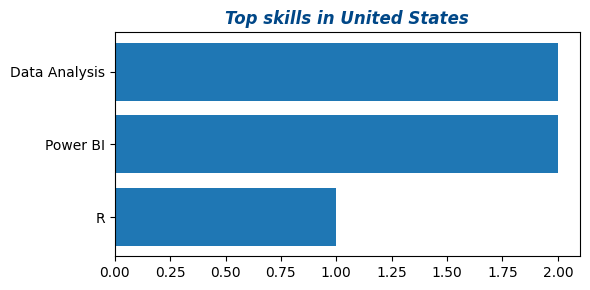

================================================================================

Top skills in Austin, TX:
[('Data Analysis', 2)]

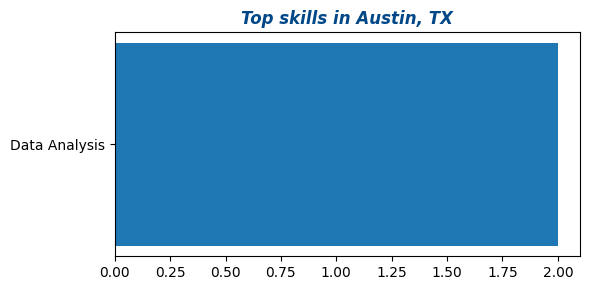

================================================================================

Top skills in Sunnyvale, CA:
[('Data Analysis', 1)]

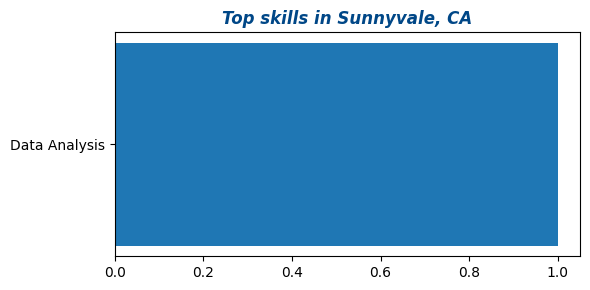

================================================================================

Top skills in Iselin, NJ:
[('Power BI', 1), ('R', 1)]

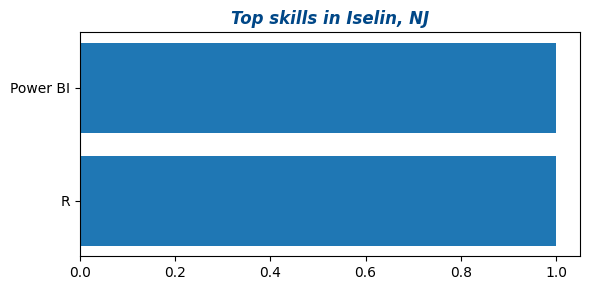

In [41]:
top_cities = df['location'].value_counts().head(4).index.tolist()
for city in top_cities:
    city_sk = Counter(s for lst in df[df['location']==city]['skills'] for s in lst)
    print("\n" * 2)
    print("[bold]=[/bold]" * 80)
    print(f"[bold]\nTop skills in {city}:[/bold]", city_sk.most_common(8))
    if city_sk:
        names, counts = zip(*city_sk.most_common(6))
        plt.figure(figsize=(6,3))
        plt.barh(list(names)[::-1], list(counts)[::-1])
        plt.title(f"Top skills in {city}", fontsize=12, fontweight='bold', style='italic', color='#004787')
        plt.tight_layout()
        plt.show()